In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
from io import BytesIO
from PIL import Image, ImageOps

from model.hybrid_forgery_detector import HybridForgeryConfig
from train import TrainConfig
BACKBONE_LRS = {"swin": 1e-4, "noise": 5e-5}
BACKBONE_WDS = {"swin": 1e-2, "noise": 1e-3}
train_config = TrainConfig(
    # backbone_learning_rates=BACKBONE_LRS,
    # backbone_weight_decays=BACKBONE_WDS,
)

model_config_kwargs = dict(
    use_efficientnet=True,
    use_swin=True,
    use_segformer=False,
    use_unet_decoder=True,
    use_skip_connections=True,
    pretrained_backbones=True,
    fused_channels= 256,
    use_noise_branch=True,
    noise_branch_base_channels=48,
    noise_branch_num_stages=4,
    noise_branch_use_residual=True,
    noise_branch_use_high_pass=True,
    backbone_input_size=train_config.target_size,
    gradient_checkpointing=False,
)

train_config.model_config = HybridForgeryConfig(**model_config_kwargs)

IMAGE_DIR = Path("sample_data")
CHECKPOINT_PATH = Path("checkpoints/BASE.pt")
THRESHOLD = 0.5

print(train_config)

c:\Users\Maranan\.conda\envs\lifd\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TrainConfig(prepared_root='prepared/CASIA2', target_size=320, train_split='train', val_split='val', batch_size=8, num_epochs=10, learning_rate=0.0001, weight_decay=0.01, num_workers=4, prefetch_factor=4, persistent_workers=True, pin_memory=None, grad_accumulation_steps=1, device=None, grad_clip_norm=1.0, log_interval=10, checkpoint_dir='checkpoints', checkpoint_interval=1, save_best_only=True, use_amp=True, use_channels_last=True, use_torch_compile=True, torch_compile_backend=None, max_train_batches=None, max_val_batches=None, resume_from=None, auto_continue_latest=True, include_aux_features=None, loss_config=LossConfig(use_bce=True, bce_weight=1.0, bce_pos_weight=None, use_dice=True, dice_weight=1.0, dice_smooth=1e-05, use_focal_tversky=False, focal_tversky_weight=0.5, focal_alpha=0.7, focal_beta=0.3, focal_gamma=1.33, use_boundary=False, boundary_weight=0.05, boundary_kernel_size=3, apply_lovasz=False, lovasz_weight=0.5), balance_real_fake=True, balanced_positive_ratio=0.5, eval_thre

In [2]:
from pathlib import Path
from PIL import Image
import numpy as np
import tifffile

from data.data_preparation import compute_high_pass
from model.hybrid_forgery_detector import HybridForgeryConfig, HybridForgeryDetector

def _predict_image_array(image_arr: np.ndarray, checkpoint_path: Path, threshold: float, compute_noise: bool = True) -> np.ndarray:
    """Run model prediction and (optionally) compute/attach noise features."""
    checkpoint = torch.load(checkpoint_path, map_location="cpu")
    cfg = HybridForgeryConfig(**checkpoint['config']['model_config'])
    device = train_config.resolved_device()
    model = HybridForgeryDetector(cfg).to(device)
    # Use a robust loader that strips common wrapper prefixes and falls back to non-strict loading
    from utils.checkpoint_utils import safe_load_state_dict_from_checkpoint
    try:
        incompat, loaded_strict = safe_load_state_dict_from_checkpoint(\
            model, checkpoint, key='model_state', map_location='cpu'\
        )
        if incompat is not None:
            print(f'Checkpoint load: missing {len(incompat.missing_keys)} keys, unexpected {len(incompat.unexpected_keys)} keys; loaded_strict={loaded_strict}')
    except Exception as e:
        print('Warning: failed to load checkpoint cleanly:', e)
        # best-effort fallback to non-strict load
        try:
            model.load_state_dict(checkpoint.get('model_state', checkpoint), strict=False)
        except Exception as e2:
            print('Error: fallback load failed:', e2)
            raise
    model.eval()
    tensor = torch.from_numpy(image_arr.transpose(2, 0, 1)).unsqueeze(0).to(device)
    noise_inputs = None
    if compute_noise and cfg.use_noise_branch:
        prep_meta = checkpoint.get('config', {}).get('preparation_config', {})
        if isinstance(prep_meta, dict):
            gaussian_radius = float(prep_meta.get('gaussian_radius', 1.0))
            normalization_mode = prep_meta.get('normalization_mode', 'zero_one')
        else:
            gaussian_radius = 1.0
            normalization_mode = 'zero_one'
        image_uint8 = (np.clip(image_arr, 0.0, 1.0) * 255.0).astype(np.uint8)
        high_pass_np, residual_np = compute_high_pass(image_uint8, gaussian_radius=gaussian_radius)
        residual_t = torch.from_numpy(residual_np.transpose(2, 0, 1)).unsqueeze(0).to(device)
        high_pass_t = torch.from_numpy(high_pass_np.transpose(2, 0, 1)).unsqueeze(0).to(device)
        noise_inputs = {'residual': residual_t, 'high_pass': high_pass_t}
    else:
        if cfg.use_noise_branch:
            zero_noise = torch.zeros(1, 3, tensor.shape[-2], tensor.shape[-1], device=device)
            noise_inputs = {'residual': zero_noise}
    with torch.no_grad():
        mask = model.predict_mask(tensor, threshold=threshold, noise_features=noise_inputs)
    return mask.squeeze().cpu().numpy()


def _load_images_from_dir(image_dir: Path, exts=(".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")) -> list[tuple[Image.Image, str]]:
    """Load images from a directory, supporting common formats including TIFF.

    TIFFs are loaded with `tifffile` when available for safer/robust handling
    of multi-page or unusual TIFF encodings; falls back to PIL otherwise.
    """
    image_dir = Path(image_dir)
    if not image_dir.exists():
        raise FileNotFoundError(f"Image directory not found: {image_dir}")
    images = []
    for p in sorted(image_dir.iterdir()):
        if p.is_file() and p.suffix.lower() in exts:
            try:
                suffix = p.suffix.lower()
                # Prefer tifffile for TIFFs if available
                if suffix in {".tif", ".tiff"} and 'tifffile' in globals() and tifffile is not None:
                    try:
                        arr = tifffile.imread(p)
                        # Ensure 3-channel RGB image
                        if arr.ndim == 2:
                            arr = np.stack([arr] * 3, axis=-1)
                        img = Image.fromarray(arr).convert("RGB")
                        images.append((img, p.name))
                        continue
                    except Exception:
                        # Fall back to PIL if tifffile fails for this file
                        pass
                # Generic fallback using PIL
                images.append((Image.open(p).convert("RGB"), p.name))
            except Exception as e:
                print(f"Warning: failed to open {p}: {e}")
    return images


C:\Users\Maranan\AppData\Local\Temp\ipykernel_11316\2058495772.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location="cp

Checkpoint load: missing 128 keys, unexpected 74 keys; loaded_strict=False


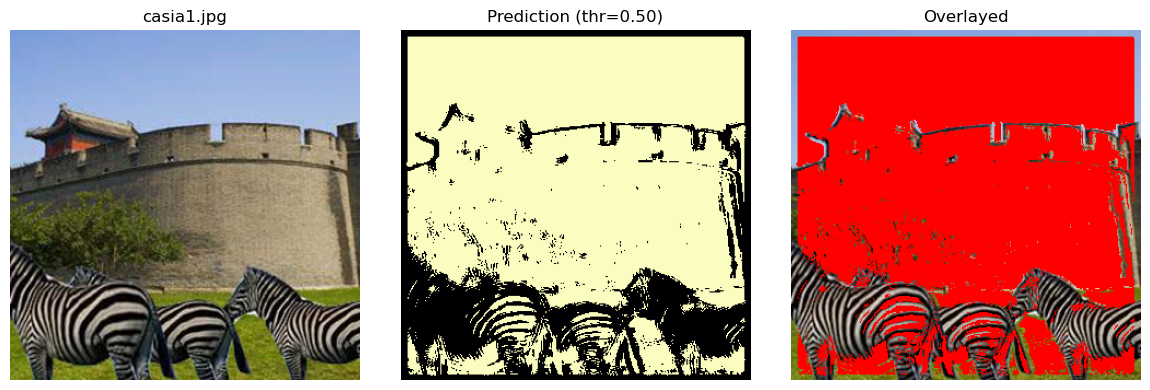

Checkpoint load: missing 128 keys, unexpected 74 keys; loaded_strict=False


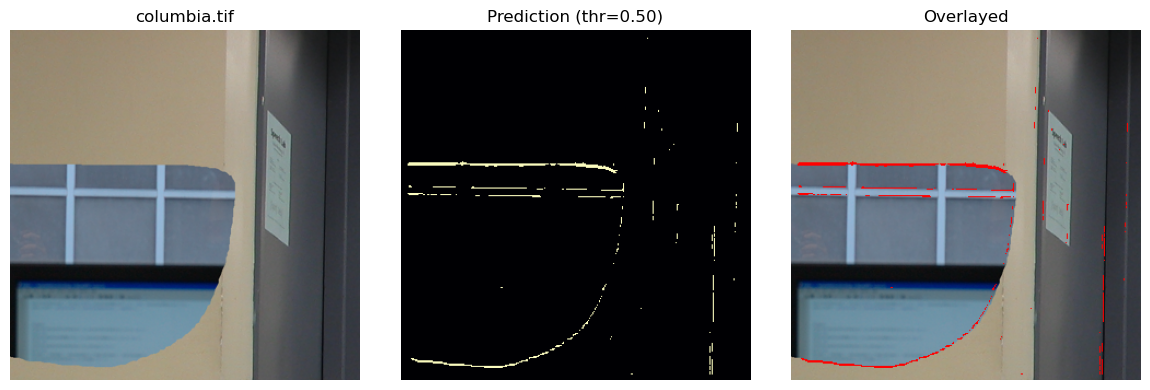

Checkpoint load: missing 128 keys, unexpected 74 keys; loaded_strict=False


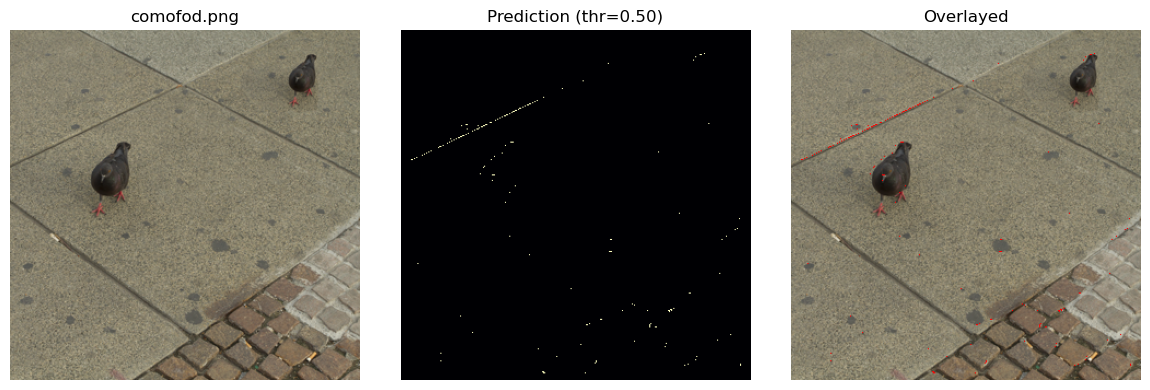

Checkpoint load: missing 128 keys, unexpected 74 keys; loaded_strict=False


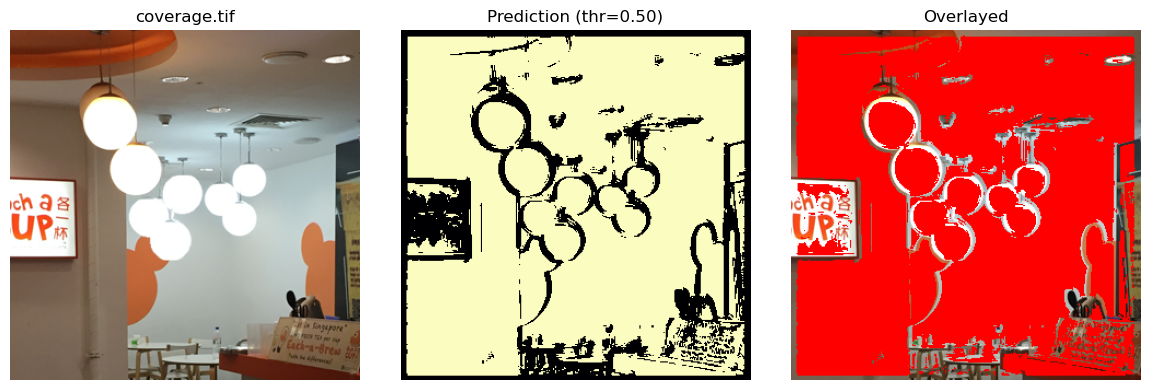

Checkpoint load: missing 128 keys, unexpected 74 keys; loaded_strict=False


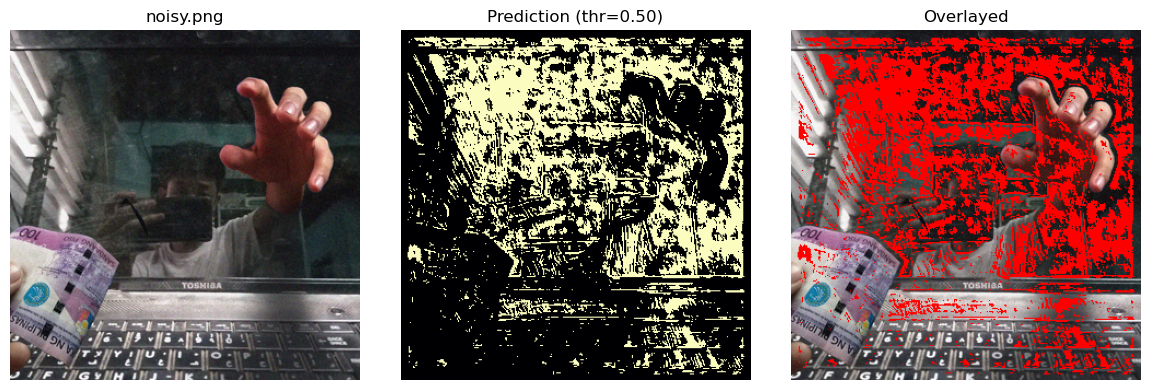

Checkpoint load: missing 128 keys, unexpected 74 keys; loaded_strict=False


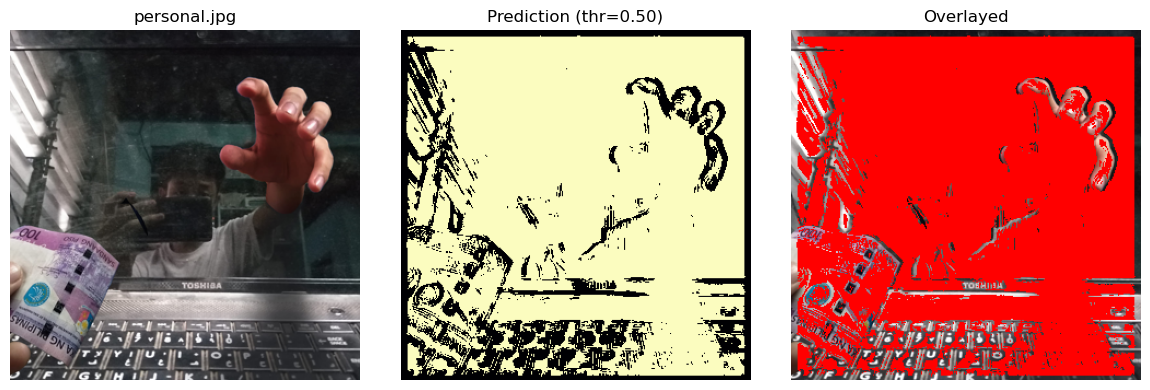

In [3]:
images = _load_images_from_dir(IMAGE_DIR)

if not images:
    print(f"No images found in {IMAGE_DIR}")
else:
    try:
        resample_mode = Image.Resampling.BICUBIC
    except AttributeError:
        resample_mode = Image.BICUBIC

    target_hw = (train_config.target_size, train_config.target_size)
    checkpoint_for_single = Path(CHECKPOINT_PATH)
    if not checkpoint_for_single.exists():
        print(f'Warning: checkpoint not found: {checkpoint_for_single}. You may need to set CHECKPOINT_PATH.')

    for uploaded_image, uploaded_label in images:
        resized_image = ImageOps.fit(uploaded_image, target_hw, method=resample_mode)
        normalized = np.array(resized_image, dtype=np.float32) / 255.0

        pred_mask = _predict_image_array(normalized, checkpoint_for_single, THRESHOLD)

        mask_uint8 = (pred_mask * 255).astype(np.uint8)
        mask_img = Image.fromarray(mask_uint8).resize(resized_image.size, resample=Image.BICUBIC)
        mask_rgba = Image.new("RGBA", resized_image.size)
        mask_rgba.paste((255, 0, 0, 128), (0, 0, resized_image.size[0], resized_image.size[1]))
        mask_rgba.putalpha(mask_img)
        resized_rgba = resized_image.convert("RGBA")
        overlayed_image = Image.alpha_composite(resized_rgba, mask_rgba)

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(resized_image)
        axes[0].set_title(uploaded_label)
        axes[0].axis('off')
        axes[1].imshow(pred_mask, cmap='magma')
        axes[1].set_title(f'Prediction (thr={THRESHOLD:.2f})')
        axes[1].axis('off')
        axes[2].imshow(overlayed_image)
        axes[2].set_title('Overlayed')
        axes[2].axis('off')
        plt.tight_layout()
        plt.tight_layout()
        plt.show()

In [4]:
import time
from pathlib import Path
import torch
from model.hybrid_forgery_detector import HybridForgeryConfig, HybridForgeryDetector

checkpoint_for_perf = Path(CHECKPOINT_PATH)
if not checkpoint_for_perf.exists():
    print(f'Checkpoint not found: {checkpoint_for_perf}. Skipping perf measurements')
else:
    checkpoint = torch.load(checkpoint_for_perf, map_location='cpu')
    cfg = HybridForgeryConfig(**checkpoint['config']['model_config'])
    device = train_config.resolved_device()
    model = HybridForgeryDetector(cfg).to(device)
    from utils.checkpoint_utils import safe_load_state_dict_from_checkpoint
    try:
        incompat, loaded_strict = safe_load_state_dict_from_checkpoint(
            model, checkpoint, key='model_state', map_location='cpu'
        )
        if incompat is not None:
            print(f'Checkpoint load: missing {len(incompat.missing_keys)} keys, unexpected {len(incompat.unexpected_keys)} keys; loaded_strict={loaded_strict}')
    except Exception as e:
        print('Warning: failed to load checkpoint cleanly:', e)
        try:
            model.load_state_dict(checkpoint.get('model_state', checkpoint), strict=False)
        except Exception as e2:
            print('Error: fallback load failed:', e2)
            raise
    model.eval()

    def count_params(m):
        total = sum(p.numel() for p in m.parameters())
        trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
        return total, trainable

    total, trainable = count_params(model)
    print(f'Total params: {total:,} ({total/1e6:.3f}M)')
    print(f'Trainable params: {trainable:,} ({trainable/1e6:.3f}M)')
    param_bytes = sum(p.numel()*p.element_size() for p in model.parameters())
    print(f'Approx model size: {param_bytes/1024/1024:.2f} MB')

    H = train_config.target_size
    W = train_config.target_size
    input_res = (3, H, W)
    flops_reported = False
    try:
        from ptflops import get_model_complexity_info
        macs, params = get_model_complexity_info(model, input_res, as_strings=False, print_per_layer_stat=False)
        print(f'ptflops MACs: {int(macs):,}')
        print(f'ptflops FLOPs (approx): {int(macs*2):,}')
        flops_reported = True
    except Exception as e_pt:
        try:
            from thop import profile
            dummy = torch.randn(1, *input_res).to(device)
            macs, params = profile(model, inputs=(dummy,), verbose=False)
            print(f'thop MACs: {int(macs):,}')
            print(f'thop FLOPs (approx): {int(macs*2):,}')
            flops_reported = True
        except Exception as e_th:
            print('ptflops/thop not available. Install `ptflops` or `thop` for MACs/FLOPs.')

    # Latency measurement (warmup + timed runs)
    dummy = torch.randn(1, *input_res).to(device)
    # warmup
    with torch.no_grad():
        for _ in range(5):
            _ = model(dummy)
    # ensure GPU warmup finished
    if hasattr(torch, 'cuda') and device.type=='cuda' and torch.cuda.is_available():
        torch.cuda.synchronize()
    N = 50
    t0 = time.time()
    with torch.no_grad():
        for _ in range(N):
            _ = model(dummy)
    if hasattr(torch, 'cuda') and device.type=='cuda' and torch.cuda.is_available():
        torch.cuda.synchronize()
    t = time.time() - t0
    avg_ms = t / N * 1000
    fps = 1 / (t / N) if t>0 else float('inf')
    print(f'Avg inference time over {N} runs: {avg_ms:.2f} ms ({fps:.2f} FPS)')

C:\Users\Maranan\AppData\Local\Temp\ipykernel_11316\517472283.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_for_perf, map_location=

Checkpoint load: missing 128 keys, unexpected 74 keys; loaded_strict=False
Total params: 37,564,624 (37.565M)
Trainable params: 37,564,624 (37.565M)
Approx model size: 143.30 MB
ptflops MACs: 262,243,155,000
ptflops FLOPs (approx): 524,486,310,000


KeyboardInterrupt: 